In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [59]:
data = pd.read_csv('/content/drive/MyDrive/California_Fire_Incidents_2013-20.csv')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AcresBurned          1633 non-null   float64
 1   Active               1636 non-null   bool   
 2   AdminUnit            1636 non-null   object 
 3   AirTankers           28 non-null     float64
 4   ArchiveYear          1636 non-null   int64  
 5   CalFireIncident      1636 non-null   bool   
 6   CanonicalUrl         1636 non-null   object 
 7   ConditionStatement   284 non-null    object 
 8   ControlStatement     105 non-null    object 
 9   Counties             1636 non-null   object 
 10  CountyIds            1636 non-null   object 
 11  CrewsInvolved        171 non-null    float64
 12  Dozers               123 non-null    float64
 13  Engines              191 non-null    float64
 14  Extinguished         1577 non-null   object 
 15  Fatalities           21 non-null     f

In [61]:
data.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,Public,SearchDescription,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,True,The Rim Fire was east of Groveland along Highw...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,...,True,The Powerhouse Fire burned in May and June 201...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30T15:28:00Z,Finalized,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,...,True,The Mountain Fire burned in July 2013 off High...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15T13:43:00Z,Finalized,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,...,True,The American Fire burned in August 2013 off De...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10T16:30:00Z,Finalized,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,...,True,"The Springs Fire burned in May 2013, Southboun...","Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02T07:01:00Z,Finalized,6.0,10.0,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0


In [62]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].median(), inplace=True)


<ipython-input-62-83397086bd0a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-62-83397086bd0a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [63]:
#define fire risk as high if AcresBurnt > 500, otherwise low
data['FireRisk'] = np.where(data['AcresBurned'] > 500, 1, 0)

In [64]:
X = data[['Latitude', 'Longitude', 'CountyIds']]  # features
y = data['FireRisk']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
#handling non-numeric columns with commas
for col in X_train.columns:
    # Remove commas if any and convert to float
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].str.replace(',', '').astype(float)
        X_test[col] = X_test[col].str.replace(',', '').astype(float)


In [66]:
# Instantiate and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7591463414634146
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       256
           1       0.43      0.31      0.36        72

    accuracy                           0.76       328
   macro avg       0.63      0.60      0.60       328
weighted avg       0.73      0.76      0.74       328

Confusion Matrix:
 [[227  29]
 [ 50  22]]


In [68]:
def predict_fire_risk(model, data, county_id):
    print()
    # Filter the data for the specified city ID
    county_data = data[data['CountyIds'] == county_id]

    # Check if the city ID exists in the dataset
    if county_data.empty:
        print(f"No data available for city ID: {county_id}")
        return None

    # Select relevant features (same features used in training)
    features = ['Latitude', 'Longitude', 'CountyIds']
    county_data = county_data[features]

    # Predict the probability of each class (Low Risk and High Risk)
    probabilities = model.predict_proba(county_data)

    # Calculate the average probability for Low Risk and High Risk
    avg_low_risk_percentage = probabilities[:, 0].mean() * 100  # Average probability of Low Risk
    avg_high_risk_percentage = probabilities[:, 1].mean() * 100  # Average probability of High Risk

    # Display the overall percentage risk for the city
    print(f"County ID: {county_id}")
    print(f"Low Risk: {avg_low_risk_percentage:.2f}%")
    print(f"High Risk: {avg_high_risk_percentage:.2f}%")

    # Create a DataFrame to hold entry indices and corresponding probabilities
    prob_df = pd.DataFrame({
        'Entry': range(1, len(probabilities) + 1),
        'Low Risk (%)': probabilities[:, 0] * 100,
        'High Risk (%)': probabilities[:, 1] * 100
    })
    print()

    # Plot the high and low risk probabilities
    prob_df.plot(x='Entry', y=['Low Risk (%)', 'High Risk (%)'], kind='bar', figsize=(10, 6), color=['blue', 'red'])
    plt.title(f"Fire Risk Probabilities for County ID {county_id}")
    plt.xlabel("Entry")
    plt.ylabel("Risk Probability (%)")
    plt.legend(title="Risk Level")
    plt.show()

    return avg_low_risk_percentage, avg_high_risk_percentage


In [69]:
def clean_numeric_columns(data):
    # Fill missing values with a default value, or use an imputation method
    data['CountyIds'] = pd.to_numeric(data['CountyIds'], errors='coerce')
    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')

    # Optionally, fill missing values with the mean or median for numerical columns
    data['CountyIds'].fillna(data['CountyIds'].median(), inplace=True)
    data['Latitude'].fillna(data['Latitude'].mean(), inplace=True)
    data['Longitude'].fillna(data['Longitude'].mean(), inplace=True)

    return data


In [70]:
def check_non_numeric_countyids(data):
    non_numeric_countyids = data[~data['CountyIds'].apply(pd.to_numeric, errors='coerce').notna()]

check_non_numeric_countyids(data)


In [71]:
# Drop rows only with missing 'Latitude' or 'Longitude', but keep those with valid 'CountyIds'
data = data.dropna(subset=['Latitude', 'Longitude'])


In [72]:
# Print available city IDs for reference
print("Available county IDs:", data['CountyIds'].unique())

Available county IDs: ['55' '19' '33' '31' '56' '10' '47' '12' '52' '45' '37' '15,56' '49' '7'
 '4' '54' '42' '22' '33,' '27' '15' '9' '36' '32' '25' '40' '20' '14' '28'
 '35' '39' '17' '1' '11' '57' '9,34' '50' '48' '24' '23' '18' '3' '58'
 '29' '43' '5' '41' '30' '49,48,17,6' '28,17' '3,9' '53' ',40' '8' '17,28'
 '14,26' '26' '34' '2' '9,31' '51' '42,56' '28,49' '28,48' '16' '27,40'
 '46' '44' '6' '21' '6,11,17,23' '45,53' '19,56' '28,57' '6,17,23' '62'
 '61' '59' '62,37']


Enter County ID: 59

County ID: 59
Low Risk: 15.00%
High Risk: 85.00%



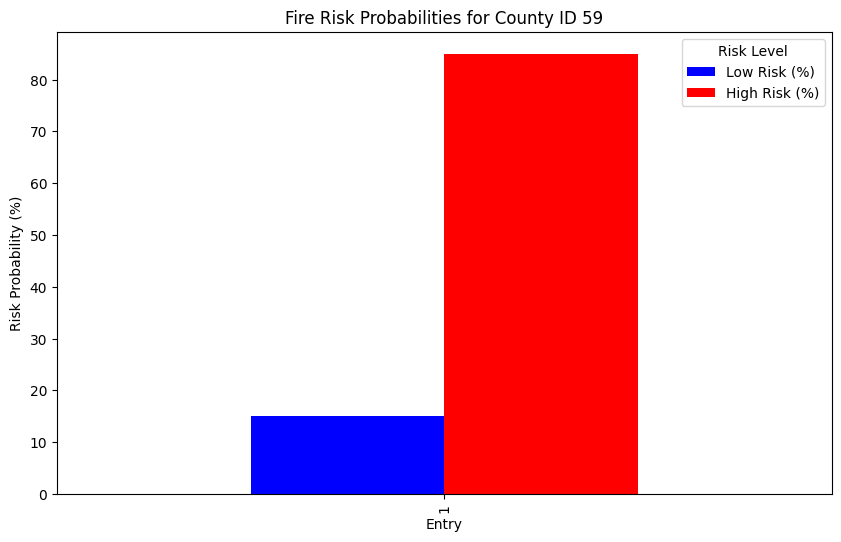

In [74]:
county_id = str(input('Enter County ID: '))
predictions = predict_fire_risk(model, data, county_id)

In [75]:
def clean_numeric_columns(data):
    # Convert columns to numeric where possible, and fill missing values with median or mean
    data['CountyIds'] = pd.to_numeric(data['CountyIds'], errors='coerce')
    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')

    # Fill missing values with median or mean
    data['CountyIds'].fillna(data['CountyIds'].median(), inplace=True)
    data['Latitude'].fillna(data['Latitude'].mean(), inplace=True)
    data['Longitude'].fillna(data['Longitude'].mean(), inplace=True)

    return data

def plot_risk_lines_by_county(model, data):

    # Clean numeric columns and prepare data
    data = clean_numeric_columns(data)

    # Convert CountyIds to numeric if they are not already
    data['CountyIds'] = pd.to_numeric(data['CountyIds'], errors='coerce')

    # Drop rows where CountyIds could not be converted to numeric
    data = data.dropna(subset=['CountyIds'])

    # Check data shape after cleaning
    print(f"Data shape after cleaning: {data.shape}")

    # Select relevant features for prediction
    features = ['Latitude', 'Longitude', 'CountyIds']
    county_data = data[features]

    # Check if county_data is empty
    print(f"County data shape: {county_data.shape}")

    if county_data.empty:
        print("No data left for prediction!")
        return

    # Predict the probability of each class
    probabilities = model.predict_proba(county_data)
    data['High Risk (%)'] = probabilities[:, 1] * 100  # High Risk probability as percentage

    # Calculate average high risk probability for each county
    avg_risk_by_county = data.groupby('CountyIds')['High Risk (%)'].mean().reset_index()

    # Sort counties by County ID
    avg_risk_by_county = avg_risk_by_county.sort_values(by='CountyIds')

    # Classify counties into low and high risk
    threshold = 50  # Define threshold for high risk
    low_risk_counties = avg_risk_by_county[avg_risk_by_county['High Risk (%)'] < threshold]
    high_risk_counties = avg_risk_by_county[avg_risk_by_county['High Risk (%)'] >= threshold]

    # Plot
    plt.figure(figsize=(12, 6))

    # Plot line for low risk counties
    plt.plot(low_risk_counties['CountyIds'], low_risk_counties['High Risk (%)'], color='blue', marker='o', label='Low Risk Counties')

    # Plot line for high risk counties
    plt.plot(high_risk_counties['CountyIds'], high_risk_counties['High Risk (%)'], color='red', marker='o', label='High Risk Counties')

    # Add labels to the points with black color
    for i, row in low_risk_counties.iterrows():
        plt.text(row['CountyIds'], row['High Risk (%)'], f"{int(row['CountyIds'])}", fontsize=8, color='black', ha='center')
    for i, row in high_risk_counties.iterrows():
        plt.text(row['CountyIds'], row['High Risk (%)'], f"{int(row['CountyIds'])}", fontsize=8, color='black', ha='center')

    # Set axis limits to spread out the points
    plt.xlim(min(avg_risk_by_county['CountyIds']) - 1, max(avg_risk_by_county['CountyIds']) + 1)

    # Customize the x-axis to avoid clustering at 0
    plt.xticks(range(int(min(avg_risk_by_county['CountyIds'])), int(max(avg_risk_by_county['CountyIds'])) + 1, 1))

    plt.xlabel('County ID (sorted)')
    plt.ylabel('Average High Risk Probability (%)')
    plt.title('Fire Risk by County (Low vs High)')
    plt.legend()
    plt.show()


<ipython-input-75-900241cf34f5>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CountyIds'].fillna(data['CountyIds'].median(), inplace=True)
<ipython-input-75-900241cf34f5>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Data shape after cleaning: (1636, 38)
County data shape: (1636, 3)


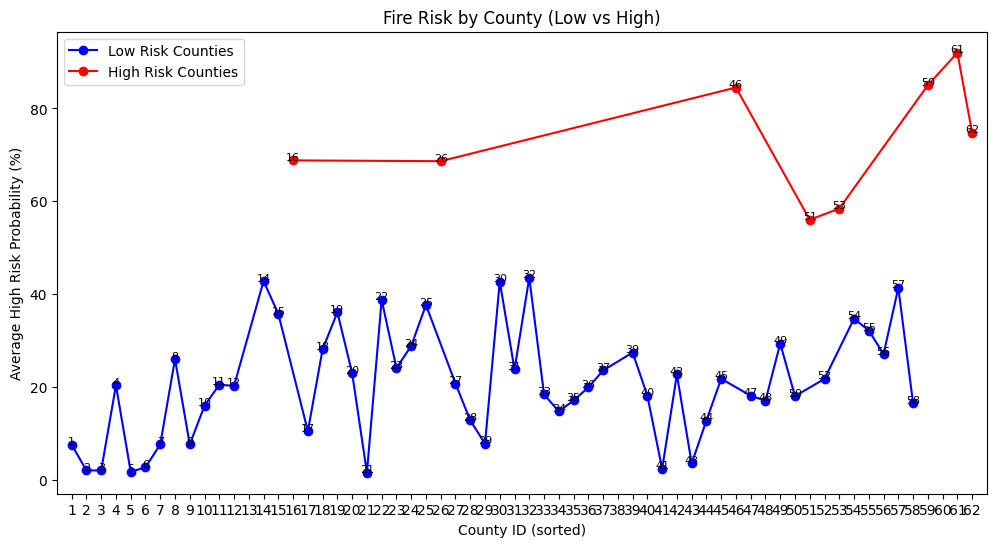

In [76]:
plot_risk_lines_by_county(model, data)